In [1]:
!pip install datasets && touch /root/.ipython/profile_default/startup/00-first.py && echo "import datasets" >> /root/.ipython/profile_default/startup/00-first.py

In [2]:
! pip install -U accelerate

In [3]:
!pip install transformers==4.44.2 huggingface_hub==0.24.7 torch umap-learn

In [4]:
# all imports required
import datasets
import transformers
import torch
import umap.umap_ as umap
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import huggingface_hub
import accelerate

In [5]:
# check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Business Objective
### Framing the Problem
Amazon wishes to improve product offerings, customer satisfaction and overrall business performance. An opportunity to solve this problem exist if we are able to derive meaning from the customer reviews

### Goal
The goal of this project is to build a sentiment analysis model that can automatically label reviews based on their sentiment, product trends and commong complaints or praises. The outcome will be a comprehensive report that provides actionable insights, using machine learning and natural language processing techniques for sentiment analysis

### Performance Measure
Accuracy will be the performance measure of choice which will be given as the ratio of number of correct predictins to total predictions.

# Get the data

In [6]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
ls /content/drive/My\ Drive/Capstone

amazon_reviews_us_Mobile_Electronics_v1_00.tsv  processed.csv  train/
dataset_dict.json                               test/          validation/


In [9]:
file_path = '/content/drive/My Drive/Capstone/amazon_reviews_us_Mobile_Electronics_v1_00.tsv'
folder_path = '/content/drive/My Drive/Capstone'

In [10]:
import pandas as pd
df = pd.read_csv(file_path, sep="\t", on_bad_lines='skip')

# Explore the data

In [11]:
df.head(3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,20422322,R8MEA6IGAHO0B,B00MC4CED8,217304173,BlackVue DR600GW-PMP,Mobile_Electronics,5.0,0.0,0.0,N,Y,Very Happy!,"As advertised. Everything works perfectly, I'm...",2015-08-31
1,US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,137313254,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5.0,0.0,1.0,N,Y,five star,it's great,2015-08-31
2,US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235,iXCC Multi pack Lightning cable,Mobile_Electronics,5.0,0.0,0.0,N,Y,great cables,These work great and fit my life proof case fo...,2015-08-31


Each row represents a review from a customer against a specific product

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104852 entries, 0 to 104851
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   marketplace        104852 non-null  object 
 1   customer_id        104852 non-null  int64  
 2   review_id          104852 non-null  object 
 3   product_id         104852 non-null  object 
 4   product_parent     104852 non-null  int64  
 5   product_title      104852 non-null  object 
 6   product_category   104852 non-null  object 
 7   star_rating        104850 non-null  float64
 8   helpful_votes      104850 non-null  float64
 9   total_votes        104850 non-null  float64
 10  vine               104850 non-null  object 
 11  verified_purchase  104850 non-null  object 
 12  review_headline    104848 non-null  object 
 13  review_body        104848 non-null  object 
 14  review_date        104850 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 1

There are 104852 instances in the dataset. for  'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase' and 'review_date' they have 104850 non-null values meaning 2 instances in each column are missing. Additionally 'review_headline' and 'review_body' have 104848 non-null values meaning 4 instances in each of the columns are missing. But this is insignificant. We take care of this later

In [13]:
# a summary of numerical attributes
df.drop(columns=["customer_id", "product_parent"]).describe()

,star_rating,helpful_votes,total_votes
count,104850.000000,104850.000000,104850.000000
mean,3.763176,1.243996,1.615393
std,1.523526,7.070387,7.909896
min,1.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000
75%,5.000000,1.000000,1.000000
max,5.000000,769.000000,791.000000


Focus on star_rating attribute we see that max rating is 5 and minimum is 1.

We have a mean of 3.763 and a standard deviation of 1.523 this suggests that the values are moderately dispersed around the mean.

Q1 = 3.0 Q2 = 4.0 and Q3 = 5 this suggests that the majority of the values in the dataset are concetrated around 3 to 5

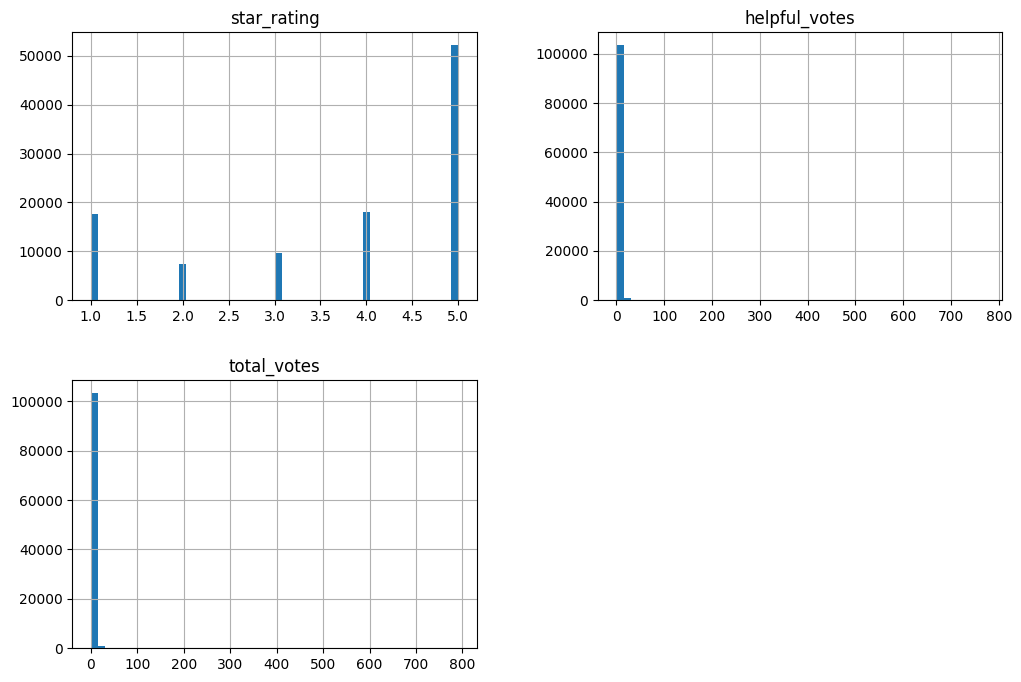

In [14]:
import matplotlib.pyplot as plt
df.drop(columns=["customer_id", "product_parent"]).hist(bins=50, figsize=(12, 8))
plt.show()

We see that rating of 5 is the majority, we have zero helpful_votes and total_votes this attributes can be dropped

In [15]:
columns_to_remove = ["helpful_votes", "total_votes"]

Transformer models have a maximum input sequence length reffered to as the maximum context size. Since Bert is our go to model it takes in text of about 512 tokens

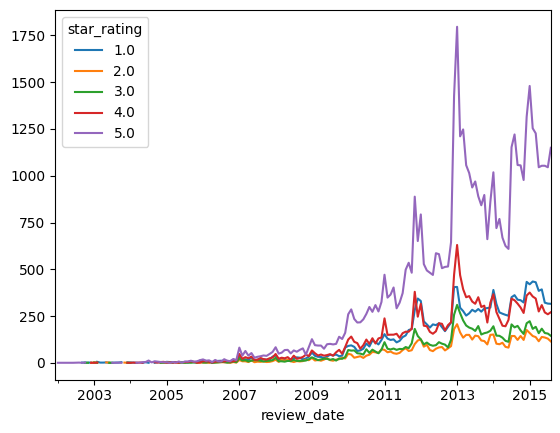

In [16]:
# view the sentiment by date
df['review_date'] = pd.to_datetime(df['review_date'])
df.groupby(df['review_date'].dt.to_period('M'))['star_rating'].value_counts().unstack().plot()
plt.show()

The trend graph illustrates the distribution of star ratings over time. The most frequently given rating is 5 stars, consistently remaining high throughout the observed period. Ratings of 1 and 2 stars are considerably lower, indicating relatively few negative reviews. Notably, there's a noticeable surge in all ratings, including 5 stars, around February 2014, potentially suggesting an increase in product purchases or customer engagement during that time. Overall, the trend reflects a generally positive customer experience with mobile electronics, with 5-star ratings consistently dominating the distribution.

# Prepare the data

### Handling missing values

In [17]:
df.isnull().sum()

,0
marketplace,0
customer_id,0
review_id,0
product_id,0
product_parent,0
product_title,0
product_category,0
star_rating,2
helpful_votes,2
total_votes,2


In [18]:
# We dont impute the missing values because they are insignificant
df = df.dropna()

### Feature selection

In [19]:
len(df), len(df[df["marketplace"] == "US"]), len(df[df["vine"] == "N"]), len(df[df["product_category"] == "Mobile_Electronics"])

(104846, 104846, 104828, 104846)

market place and vine have have no unique characteristics so drop this attributes

In [20]:
columns_to_remove.append("marketplace"), columns_to_remove.append("vine"), columns_to_remove.append("product_parent"), columns_to_remove.append("review_id"), columns_to_remove.append("product_category")

(None, None, None, None, None)

In [21]:
print(columns_to_remove)

['helpful_votes', 'total_votes', 'marketplace', 'vine', 'product_parent', 'review_id', 'product_category']


In [22]:
df = df.drop(columns=columns_to_remove, errors="ignore")

In [23]:
df.head(3)

,customer_id,product_id,product_title,star_rating,verified_purchase,review_headline,review_body,review_date
0,20422322,B00MC4CED8,BlackVue DR600GW-PMP,5.0,Y,Very Happy!,"As advertised. Everything works perfectly, I'm...",2015-08-31
1,40835037,B00OQMFG1Q,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,5.0,Y,five star,it's great,2015-08-31
2,51469641,B00QERR5CY,iXCC Multi pack Lightning cable,5.0,Y,great cables,These work great and fit my life proof case fo...,2015-08-31


### Feature engineering
Labeling the sentiment as positive, neutral and negative we assume that;

1. 1–2 stars = Negative
2. 3 stars = Neutral
3. 4–5 stars = Positive

In [24]:
def sentiment_label(rate):
    if rate <= 2:
        return 'Negative'
    elif rate == 3:
        return 'Neutral'
    else:
        return 'Positive'

In [25]:
df["sentiment"] = df["star_rating"].apply(sentiment_label)

<Axes: xlabel='review_date'>

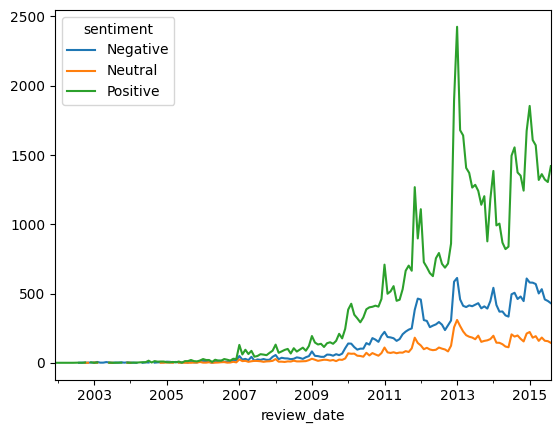

In [26]:
# view the sentiment by date
df['review_date'] = pd.to_datetime(df['review_date'])
df.groupby(df['review_date'].dt.to_period('M'))['sentiment'].value_counts().unstack().plot()

The trend graph illustrates the distribution of sentiments over time. Positive sentiment demonstrates a general upward trend, while negative sentiment gradually decreases. Neutral sentiment remains relatively stable with minor fluctuations. There's a noticeable surge in positive reviews around 2010 and 2013, possibly indicating a successful product launch or marketing campaign. Overall, customer sentiment appears to be increasingly positive over the observed period.

In [27]:
df.columns

Index(['customer_id', 'product_id', 'product_title', 'star_rating',
       'verified_purchase', 'review_headline', 'review_body', 'review_date',
       'sentiment'],
      dtype='object')

In [28]:
df.to_csv(f'{folder_path}/processed.csv')

Combine review headline and review_body

In [29]:
df["review"] = df["review_headline"] + " " + df["review_body"]

In [30]:
df = df.drop(columns=["review_headline", "review_body"], errors="ignore")

In [31]:
df.head(10)

,customer_id,product_id,product_title,star_rating,verified_purchase,review_date,sentiment,review
0,20422322,B00MC4CED8,BlackVue DR600GW-PMP,5.0,Y,2015-08-31,Positive,Very Happy! As advertised. Everything works pe...
1,40835037,B00OQMFG1Q,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,5.0,Y,2015-08-31,Positive,five star it's great
2,51469641,B00QERR5CY,iXCC Multi pack Lightning cable,5.0,Y,2015-08-31,Positive,great cables These work great and fit my life ...
3,4332923,B00QUFTPV4,abcGoodefg® FBI Covert Acoustic Tube Earpiece ...,4.0,Y,2015-08-31,Positive,Work very well but couldn't get used to not he...
4,44855305,B0067XVNTG,Generic Car Dashboard Video Camera Vehicle Vid...,2.0,Y,2015-08-31,Negative,Cameras has battery issues Be careful with the...
5,7846966,B00KA6CCVY,Aweek® Air Acoustic Earpiece Headset for Baofe...,3.0,Y,2015-08-31,Neutral,"It appears to be good, but I'm still waiting f..."
6,21299354,B00MJCDPM2,Sentey LS-4460 B-Trek S8 Bluetooth Portable St...,3.0,Y,2015-08-31,Neutral,Didn't love the first one First one arrived as...
7,28902968,B00ET5AWBY,iPad Car Headrest Mount Holder for iPad 2/ iPa...,5.0,Y,2015-08-31,Positive,Five Stars Worked great for vacation
8,2074438,B00Z9K379C,ANWING Waterproof Wireless Bluetooth Speaker O...,4.0,Y,2015-08-31,Positive,"Four Stars this is a very good item, it provid..."
9,48701722,B00YO3UYXW,Jensen MCR-100 Cassette Player/Recorder 1 Touc...,5.0,Y,2015-08-31,Positive,I LOVE my recorder I LOVE my recorder. Bought ...


We can see that the highest token is 175 so it is within Bert models context size of 512

### Text processing
Here we convert the raw texts into a format suitable for transformers. Transformers like DistilBert assume that text has been tokenized and econded as numerical vectors (embeddings)

We use a tokenizer associated with Bert and DistilBert models our model of choice fo sentiment analysis

In [32]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


#### Tokenizer in action

In [33]:
# testing the tokenizer
text = df.iloc[0]["review"]
text

"Very Happy! As advertised. Everything works perfectly, I'm very happy with the camera. As a matter of fact I'm going to buy another one for my 2nd car."

In [34]:
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 2200, 3407, 999, 2004, 17099, 1012, 2673, 2573, 6669, 1010, 1045, 1005, 1049, 2200, 3407, 2007, 1996, 4950, 1012, 2004, 1037, 3043, 1997, 2755, 1045, 1005, 1049, 2183, 2000, 4965, 2178, 2028, 2005, 2026, 3416, 2482, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

You can see that the words have been mapped to unique integers in the input_ids field

In [35]:
# converting the input_ids into their correspoiding text
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'very', 'happy', '!', 'as', 'advertised', '.', 'everything', 'works', 'perfectly', ',', 'i', "'", 'm', 'very', 'happy', 'with', 'the', 'camera', '.', 'as', 'a', 'matter', 'of', 'fact', 'i', "'", 'm', 'going', 'to', 'buy', 'another', 'one', 'for', 'my', '2nd', 'car', '.', '[SEP]']


In [36]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] very happy! as advertised. everything works perfectly, i ' m very happy with the camera. as a matter of fact i ' m going to buy another one for my 2nd car. [SEP]


You can observe
- [CLS] at the beginning and [SEP] at the end of the sequence. They are used to indicate the start and end of a sequence.
- The tokens have been lowercased

In [37]:
tokenizer.vocab_size # explore the vocabulary size

30522

In [38]:
tokenizer.model_max_length # the maximum content size

512

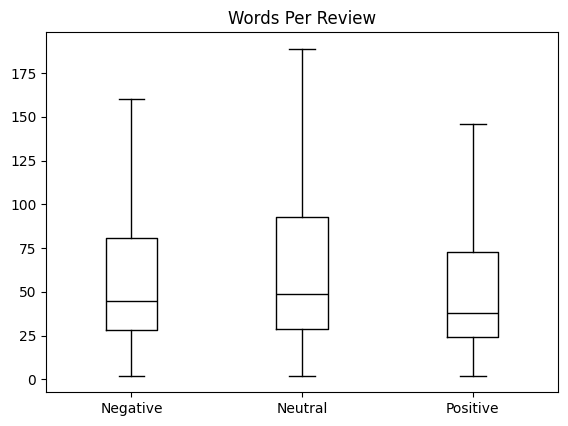

In [39]:
# check the length of reviews
df["Words Per Review"] = df["review"].astype(str).str.split().apply(len)
df.boxplot("Words Per Review", by="sentiment", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

This is the maximu length of input text the model expects

In [40]:
tokenizer.model_input_names # name of the fields the model expects in its forward pass

['input_ids', 'attention_mask']

#### Split the data into training testing and validation set

In [41]:
df = df.drop(columns=["star_rating", "verified_purchase", "review_date"], errors="ignore") # drop other columns we don't need
df.head()

,customer_id,product_id,product_title,sentiment,review,Words Per Review
0,20422322,B00MC4CED8,BlackVue DR600GW-PMP,Positive,Very Happy! As advertised. Everything works pe...,28
1,40835037,B00OQMFG1Q,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Positive,five star it's great,4
2,51469641,B00QERR5CY,iXCC Multi pack Lightning cable,Positive,great cables These work great and fit my life ...,15
3,4332923,B00QUFTPV4,abcGoodefg® FBI Covert Acoustic Tube Earpiece ...,Positive,Work very well but couldn't get used to not he...,31
4,44855305,B0067XVNTG,Generic Car Dashboard Video Camera Vehicle Vid...,Negative,Cameras has battery issues Be careful with the...,28


In [42]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [43]:
# load the data into hugging face compatible data structure
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

review_data_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

review_data_dict

DatasetDict({
    train: Dataset({
        features: ['customer_id', 'product_id', 'product_title', 'sentiment', 'review', 'Words Per Review', '__index_level_0__'],
        num_rows: 67100
    })
    validation: Dataset({
        features: ['customer_id', 'product_id', 'product_title', 'sentiment', 'review', 'Words Per Review', '__index_level_0__'],
        num_rows: 16776
    })
    test: Dataset({
        features: ['customer_id', 'product_id', 'product_title', 'sentiment', 'review', 'Words Per Review', '__index_level_0__'],
        num_rows: 20970
    })
})

In [44]:
review_data_dict = review_data_dict.remove_columns(["__index_level_0__"])

Create a special ClassLabel object for sentiment which will contain information about the class names and their mapping to integers

In [45]:
from datasets import ClassLabel
#convert the sentiment into class label
review_data_dict = review_data_dict.cast_column("sentiment", ClassLabel(names=['Negative', 'Neutral', 'Positive']))
review_data_dict['train'].features


Casting the dataset:   0%|          | 0/67100 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/16776 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/20970 [00:00<?, ? examples/s]

{'customer_id': Value(dtype='int64', id=None),
 'product_id': Value(dtype='string', id=None),
 'product_title': Value(dtype='string', id=None),
 'sentiment': ClassLabel(names=['Negative', 'Neutral', 'Positive'], id=None),
 'review': Value(dtype='string', id=None),
 'Words Per Review': Value(dtype='int64', id=None)}

In [46]:
review_data_dict["test"].features["sentiment"]

ClassLabel(names=['Negative', 'Neutral', 'Positive'], id=None)

In [47]:
review_data_dict["validation"].features["sentiment"]

ClassLabel(names=['Negative', 'Neutral', 'Positive'], id=None)

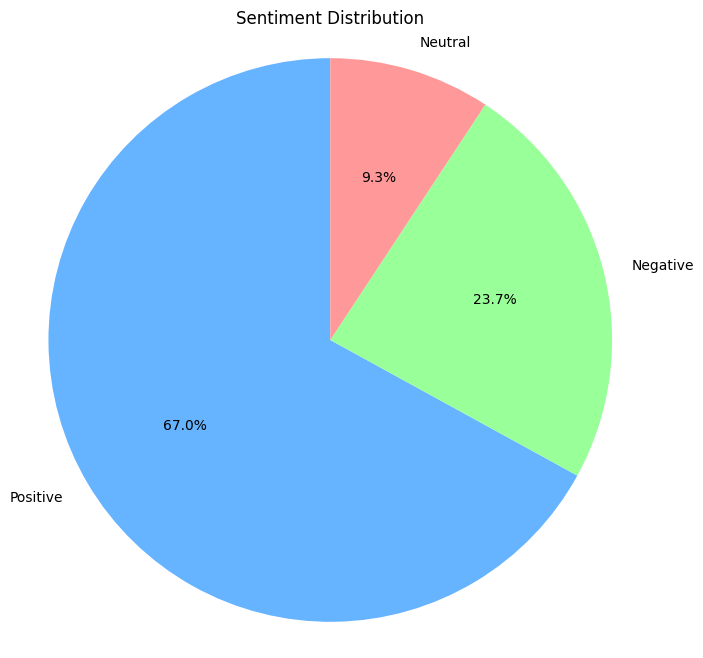

In [48]:
import matplotlib.pyplot as plt

# Get sentiment counts directly from the Pandas Series
sentiment_counts = df['sentiment'].value_counts()

# Convert to NumPy array for pie chart plotting
sentiment_counts_np = sentiment_counts.to_numpy()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts_np, labels=sentiment_counts.index, autopct='%1.1f%%',
        colors=['#66b3ff','#99ff99','#ff9999'], startangle=90)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle
plt.show()

#### Tokenizing the text corpus

In [49]:
# Tokenizing the whole dataset
def tokenize(batch):
  #
  return tokenizer(batch["review"], # tokenize the column review
                   padding=True, # pad to the size of the longest input in the batch
                   truncation=True) # then truncate to the model's maximum context size

review_encoded = review_data_dict.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/67100 [00:00<?, ? examples/s]

Map:   0%|          | 0/16776 [00:00<?, ? examples/s]

Map:   0%|          | 0/20970 [00:00<?, ? examples/s]

In [50]:
# after tokenizing the resulting dataset also include input_ids and attention_masks
print(review_encoded["train"].column_names)

['customer_id', 'product_id', 'product_title', 'sentiment', 'review', 'Words Per Review', 'input_ids', 'attention_mask']


In [51]:
# Save procesed data
review_encoded.save_to_disk(folder_path)

Saving the dataset (0/1 shards):   0%|          | 0/67100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/16776 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/20970 [00:00<?, ? examples/s]

# Training a text classifier

In [52]:
file_path = '/content/drive/My Drive/Capstone/amazon_reviews_us_Mobile_Electronics_v1_00.tsv'
folder_path = '/content/drive/My Drive/Capstone'

In [53]:
from datasets import load_from_disk
review_encoded = load_from_disk(folder_path)
review_encoded

DatasetDict({
    train: Dataset({
        features: ['customer_id', 'product_id', 'product_title', 'sentiment', 'review', 'Words Per Review', 'input_ids', 'attention_mask'],
        num_rows: 67100
    })
    validation: Dataset({
        features: ['customer_id', 'product_id', 'product_title', 'sentiment', 'review', 'Words Per Review', 'input_ids', 'attention_mask'],
        num_rows: 16776
    })
    test: Dataset({
        features: ['customer_id', 'product_id', 'product_title', 'sentiment', 'review', 'Words Per Review', 'input_ids', 'attention_mask'],
        num_rows: 20970
    })
})

In [54]:
# the pretrained model key
model_ckpt = "distilbert-base-uncased"

In [55]:
from transformers import AutoModel
import torch

# check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModel.from_pretrained(model_ckpt).to(device) # add model to the device usint .to

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

## Get the hidden state for the dataset
We create a new hidden_state column to store all the vectors

In [56]:
# Function to extract hidden states
def extract_hidden_states(batch):
    # move model to right device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Place model inputs on the device
    inputs = {k: v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}

    # Extract last hidden states with gradient computation turned off
    with torch.no_grad():
        # Try to reduce memory usage by deleting intermediate tensors
        last_hidden_state = model(**inputs).last_hidden_state
        del inputs  # Delete inputs after use

    # Return vector for [CLS] token, place it back to CPU as a Numpy array
    # Move the hidden state to CPU before converting to NumPy to free GPU memory
    hidden_state_cpu = last_hidden_state[:, 0].cpu()
    del last_hidden_state  # Delete the GPU tensor
    return {"hidden_state": hidden_state_cpu.numpy()}

In [57]:
review_encoded["train"].features

{'customer_id': Value(dtype='int64', id=None),
 'product_id': Value(dtype='string', id=None),
 'product_title': Value(dtype='string', id=None),
 'sentiment': ClassLabel(names=['Negative', 'Neutral', 'Positive'], id=None),
 'review': Value(dtype='string', id=None),
 'Words Per Review': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [58]:
# convert the input_ids and attention_mask columns to tensors for the model inputs
review_encoded.set_format("torch", columns=["input_ids", "attention_mask", "sentiment"])

In [59]:
# then we extract the hidden inputs accross the splits in one go
review_hidden = review_encoded.map(
    extract_hidden_states,
    batched=True,
    batch_size=50,
    num_proc=1
)


In [60]:
# after applying the extract_hidden_function() it adds
# a new hidden_state column to the dataset
review_hidden["train"].column_names

['customer_id',
 'product_id',
 'product_title',
 'sentiment',
 'review',
 'Words Per Review',
 'input_ids',
 'attention_mask',
 'hidden_state']

In [61]:
# Creating a feature matrix
import numpy as np
# hidden state of dataset features on train and validation as input features
X_train = np.array(review_hidden["train"]["hidden_state"])
X_valid = np.array(review_hidden["validation"]["hidden_state"])
# sentiment of dataset features on train and validation as targets
y_train = np.array(review_hidden["train"]["sentiment"])
y_valid = np.array(review_hidden["validation"]["sentiment"])
X_train.shape, X_valid.shape

((67100, 768), (16776, 768))

In [62]:
# Visualizing the training set
import pandas as pd
from umap.umap_ import UMAP # project the 768 dimension of hidden state to 2 D
from sklearn.preprocessing import MinMaxScaler
# scale features to [0, 1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["sentiment"] = y_train
df_emb.head()


,X,Y,sentiment
0,13.977188,3.270870,0
1,10.463495,7.493412,2
2,13.445863,3.643089,2
3,13.611381,5.979329,0
4,12.365322,6.394207,2


result a hidden_state from 768 dim to 2 dim df_emb contains the hidden states in 2D

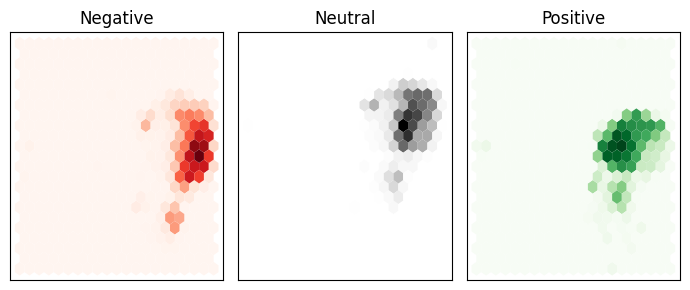

In [63]:
import matplotlib.pyplot as plt
# plot the hidden states in 2D
fig, axes = plt.subplots(1, 3, figsize=(7,3))
axes = axes.flatten()
cmaps = ["Reds", "Greys", "Greens"] # 3 emotions
labels = review_encoded["train"].features["sentiment"].names # 3 targets classifying the emotions

for i, (sentiment, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"sentiment == {i}") # query the sentiment of the hidden_state
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"],
                 cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(sentiment)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

plt.tight_layout()
plt.show()

## Train a simple classifier

In [64]:
# Training a simple classifier
from sklearn.linear_model import LogisticRegression
# We increase "max_iter" to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000) # LogisticRegression
lr_clf.fit(X_train, y_train) # the hidden state training set and the target
lr_clf.score(X_valid, y_valid) # validate the model on the validation set

0.8582498807820697

The model has an accuracy of 85% that is very impressive for a simple classifer. But there is a catch remember our dataset was unbalance having star rating of five as significant.

We can examine whether our model is actually good by comparing against a baseline in from Scikit-learn Dummy Classifier model

The DummyClassifier is used to build a classifer with simple heuristics such as always choosing the majoirity class and always drawing a random class

In [65]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.6684549356223176

We see that still the logistic regressor performs better than the baseline classifier

### confusion matrix for logistic regression model
To get the relationship between the true and predicted labels

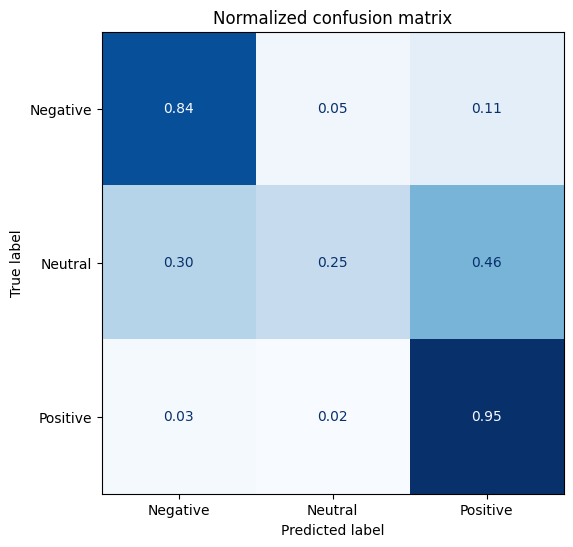

In [66]:
# To get the relationship between the true and predicted labels
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid) # get the predictions
# plot the confusion matrix with the predicitons
plot_confusion_matrix(y_preds, y_valid, labels)

We see the model is finding it difficult to differentiate neutral from positive. Lets see if we can improve this by transfer learining on pretrained distilBert model

## Train a pretrained distilbert as text classifer

In [67]:
review_encoded["train"].features

{'customer_id': Value(dtype='int64', id=None),
 'product_id': Value(dtype='string', id=None),
 'product_title': Value(dtype='string', id=None),
 'sentiment': ClassLabel(names=['Negative', 'Neutral', 'Positive'], id=None),
 'review': Value(dtype='string', id=None),
 'Words Per Review': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

Rename the sentiment column into label since pretrained BERT models expect label key in the input dictionary not sentiment

In [68]:
review_encoded = review_encoded.rename_column("sentiment", "label")

In [69]:
num_labels = len(review_encoded["train"].features["label"].names)

In [70]:
batch_size = 16

In [71]:
from transformers import AutoModelForSequenceClassification
num_labels = len(review_encoded["train"].features["label"].names)
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                num_labels=num_labels).to(device))

#Training the model
from transformers import Trainer, TrainingArguments

logging_steps = len(review_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  gradient_accumulation_steps=4,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [72]:
# function to calculate f1 score and accuracy
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

Login into hugging face account this will allow pushing of our finetuned model to our account on the hub and share with the community

In [73]:
from huggingface_hub import notebook_login
notebook_login()

In [74]:
#Training the model
from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = len(review_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"  # the model from transfer learning
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=4,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  gradient_accumulation_steps=4,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,  # after training push it to hub
                                  log_level="error")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [75]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=review_encoded["train"],
                  eval_dataset=review_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,No log,0.252265,0.902718,0.892051
2,No log,0.312901,0.900036,0.902204


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,No log,0.252265,0.902718,0.892051
2,No log,0.312901,0.900036,0.902204
3,No log,0.387618,0.898605,0.899977


TrainOutput(global_step=4192, training_loss=0.1710898275593765, metrics={'train_runtime': 12558.0292, 'train_samples_per_second': 21.373, 'train_steps_per_second': 0.334, 'total_flos': 3.5538457608474624e+16, 'train_loss': 0.1710898275593765, 'epoch': 3.9980925131139724})

We have an accuracy of 90% and an F1 score of 90%. A pretty good performance considering the required threshold is an accuracy of 80%

In [76]:
# To visualize the confusion matrix pass the validation set to the .predict()
preds_output = trainer.predict(review_encoded["validation"])

In [77]:
# the metrics on the validation set
preds_output.metrics

{'test_loss': 0.38761797547340393,
 'test_accuracy': 0.8986051502145923,
 'test_f1': 0.8999772460172016,
 'test_runtime': 263.4074,
 'test_samples_per_second': 63.688,
 'test_steps_per_second': 3.982}

- test_loss: 0.2469: The loss function quantifies the difference between the model's predictions and the actual labels. A lower value indicates better performance, with 0.2469 suggesting good performance.
- test_accuracy: 0.9084: This is the percentage of correct predictions out of the total. A value of 0.9084 means the model correctly classified about 90.8% of the test data.
- test_f1: 0.9054: The F1-score balances precision and recall, giving a combined measure of model performance. A score of 0.9054 indicates a strong balance between precision and recall.
- test_runtime: 302.5419: The total time (in seconds) taken to run the test evaluation.
- test_samples_per_second: 55.45: The number of test samples processed per second, indicating the speed of evaluation.
- test_steps_per_second: 3.467: The number of steps (batches) processed per second during the test run.

In [78]:
# To decode predictions greedily use np.argmax
y_preds = np.argmax(preds_output.predictions, axis=1)

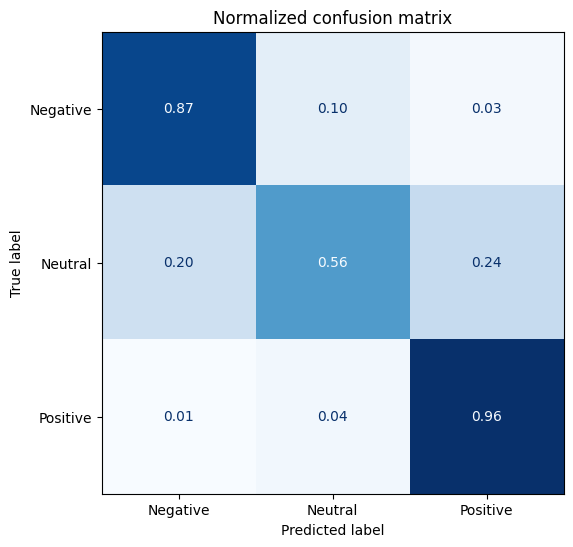

In [79]:
# with predictins we can plot the confusion matrix again
plot_confusion_matrix(y_preds, y_valid, labels)

Comparing the confusion matrices of the simple logistic regressor and the fine-tuned DistilBERT model reveals significant differences in their performance.

The simple logistic regressor demonstrated difficulties in distinguishing between neutral and positive sentiments, as evident in the confusion matrix. This suggests the model might be struggling to capture the subtle nuances within the data, particularly in distinguishing the positive and neutral.

The fine-tuned DistilBERT model exhibits a much-improved ability to differentiate between sentiment classes, including the neutral and positive sentiments. The clearer diagonal pattern in its confusion matrix indicates a greater accuracy in predicting sentiment labels, which is consistent with its higher overall performance metrics.

This improvement showcases the advantage of leveraging a more sophisticated language model like DistilBERT for sentiment analysis tasks.
Furthermore, the fine-tuned DistilBERT model seems better at understanding contextual elements within reviews, leading to a more nuanced classification of sentiments.

In conclusion, the fine-tuned DistilBERT model proves to be significantly more effective for sentiment classification compared to the simple logistic regressor. Its ability to differentiate sentiment classes with higher precision makes it a more reliable and robust solution for this task.

### Fetch the model from hugging face
During training the model is saved when training args push_to_hub is set to true

In [80]:
from huggingface_hub import notebook_login
notebook_login()

In [81]:
# Specify the model path from hugging face hub
model_name = "Nithish7994/distilbert-base-uncased-finetuned-emotion"

In [82]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [83]:
file_path = '/content/drive/My Drive/Capstone/amazon_reviews_us_Mobile_Electronics_v1_00.tsv'
folder_path = '/content/drive/My Drive/Capstone'
from datasets import load_from_disk
data = load_from_disk(folder_path)
data

DatasetDict({
    train: Dataset({
        features: ['customer_id', 'product_id', 'product_title', 'sentiment', 'review', 'Words Per Review', 'input_ids', 'attention_mask'],
        num_rows: 67100
    })
    validation: Dataset({
        features: ['customer_id', 'product_id', 'product_title', 'sentiment', 'review', 'Words Per Review', 'input_ids', 'attention_mask'],
        num_rows: 16776
    })
    test: Dataset({
        features: ['customer_id', 'product_id', 'product_title', 'sentiment', 'review', 'Words Per Review', 'input_ids', 'attention_mask'],
        num_rows: 20970
    })
})

In [84]:
def sample_prediction(text):
  # Tokenize the input text
  inputs = tokenizer(text, return_tensors="pt")
  # Make predictions
  with torch.no_grad():  # Disable gradient calculation save on memory
      outputs = model(**inputs)
  # Get the predicted class
  logits = outputs.logits
  predicted_class = logits.argmax(dim=-1).item()  # Get the class index with the highest score

  sentiment = data["train"].features["sentiment"].names[predicted_class]

  print(f"The predicted class is: {predicted_class} of emotion {sentiment}")

In [85]:
# Sample input text
text = "I love this product! It's fantastic."
sample_prediction(text)

The predicted class is: 2 of emotion Positive


### Error analysis

In [86]:
next(model.parameters()).device

device(type='cpu')

In [87]:
# Error analysis
from torch.nn.functional import cross_entropy

# make sure model is in the right device
model.to(device)

# a function that returns the loss along with the predicted sentiment
def forward_pass_with_label(batch):
  # place all input tensors on the same device as the model
  inputs = {k: v.to(device) for k, v in batch.items()
            if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=1)
    loss = cross_entropy(output.logits, batch["label"].to(device),
                         reduction="none")
  # place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(),
          "predicted_label": pred_label.cpu().numpy()}

In [88]:
# using map() to apply the above function to get loses of the samples
# convert our dataset back to PyTorch tensors
review_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

# compute loss values
review_encoded["validation"]  = review_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16
)


Map:   0%|          | 0/16776 [00:00<?, ? examples/s]

In [89]:
# Then we create a DataFrame with the texts, losses ad predicted/true labels
review_encoded.set_format("pandas") # format the encodings to pandas
cols = ["review", "label", "predicted_label", "loss"] # the columns
df_test = review_encoded["validation"][:][cols] # for the validation set everything according to the columns
df_test["label"] = df_test["label"].apply(sentiment_label) # convert the label into strings
df_test["predicted_labels"] = (df_test["predicted_label"].apply(sentiment_label)) # the predicted sentiment into string

In [90]:
# having the highest loss function probably bad production
df_test.sort_values("loss", ascending=False).head(10)

,review,label,predicted_label,loss,predicted_labels
9444,Great sound I am thrilled with the sound quali...,Negative,2,9.025824,Negative
5105,Great Player... EXCELLENT SERVICE!! After read...,Negative,2,8.914324,Negative
2086,Perfect factory upgrade for Dodge Durango (200...,Negative,2,8.905720,Negative
12666,"was a Good product. Works as advertised, needs...",Negative,2,8.826907,Negative
11171,"Five Stars Love this product, however it did n...",Negative,2,8.615053,Negative
12869,"Does what it is supposed to do, makes the devi...",Negative,2,8.537231,Negative
7700,"The ""UNLOCK"" feature didn't work out of the bo...",Negative,2,8.445516,Negative
6536,"Wrong product description, great CCA wire. Des...",Negative,2,8.378078,Negative
8321,Definitely not for wearing The picture doesn't...,Negative,2,8.341147,Negative
4416,LifeDrive Battery This would be a great produc...,Negative,2,8.286491,Negative


In [91]:
# with the lowest function is. i.e., prediction model is most confident about
df_test.sort_values("loss", ascending=True).head(10)

,review,label,predicted_label,loss,predicted_labels
2677,Five Stars Daughter was very extatic to receiv...,Negative,2,0.000328,Negative
7933,Five Stars good price works just as good as oe...,Negative,2,0.000328,Negative
4042,Kenwood Excelon KFC-XW1200F This sub really de...,Negative,2,0.000328,Negative
11021,Five Stars Great buy. Exactly as described. If...,Negative,2,0.000331,Negative
10111,Five Stars Very Good product compared to other...,Negative,2,0.000335,Negative
4531,Five Stars Device is as advertised and low price,Negative,2,0.000336,Negative
5750,"Five Stars Good product, as advertised.",Negative,2,0.000336,Negative
9415,Five Stars This radio case works great with my...,Negative,2,0.000338,Negative
14459,Five Stars Good value and product description....,Negative,2,0.000339,Negative
9422,Five Stars Its a new one and works fine. I pr...,Negative,2,0.000339,Negative


From here we see that the positive sentiment is mislabled as negative and the model is most confident about predicting the label negative.

In [92]:
# saving and sharing the model push the model to the hub
trainer.push_to_hub(commit_message="Training completed!")

events.out.tfevents.1733853924.47ee899635ce.3741.0:   0%|          | 0.00/6.86k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Nithish7994/distilbert-base-uncased-finetuned-emotion/commit/f8c670f8ee3879a82d8c4e190827b6be683fc5ef', commit_message='Training completed!', commit_description='', oid='f8c670f8ee3879a82d8c4e190827b6be683fc5ef', pr_url=None, pr_revision=None, pr_num=None)

## Using distilBert finetuned to make predictions

In [93]:
# using the model to predict on new sentiment
# we load the model from the hub using the pipeline function
# get the model from the hub
from transformers import pipeline
model_id = "Nithish7994/distilbert-base-uncased-finetuned-emotion" # the model id
classifier = pipeline("text-classification", model=model_id) # using pipeline to get the model

In [94]:
# plotting the probability for each class in a bar plot
import matplotlib.pyplot as plt
import pandas as pd
import random
import textwrap

def plot_preds(labels, num_samples=12):
  test_data = review_encoded["test"]["review"]   # the testing set

  plt.figure(figsize=(20, 50))
  for i in range(num_samples):
    index = random.randint(0, len(test_data))
    review = test_data[index]   # retrieve a random review from test set
    preds = classifier(review, return_all_scores=True)  # classify the review

    plt.subplot(int(num_samples/1), 2, i+1)    # plot at position
    preds_df = pd.DataFrame(preds[0])
    plt.bar(labels, 100*preds_df["score"], color="C0")
    plt.title(textwrap.fill(review, width=50)[:200])

  plt.tight_layout()
  plt.show()

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


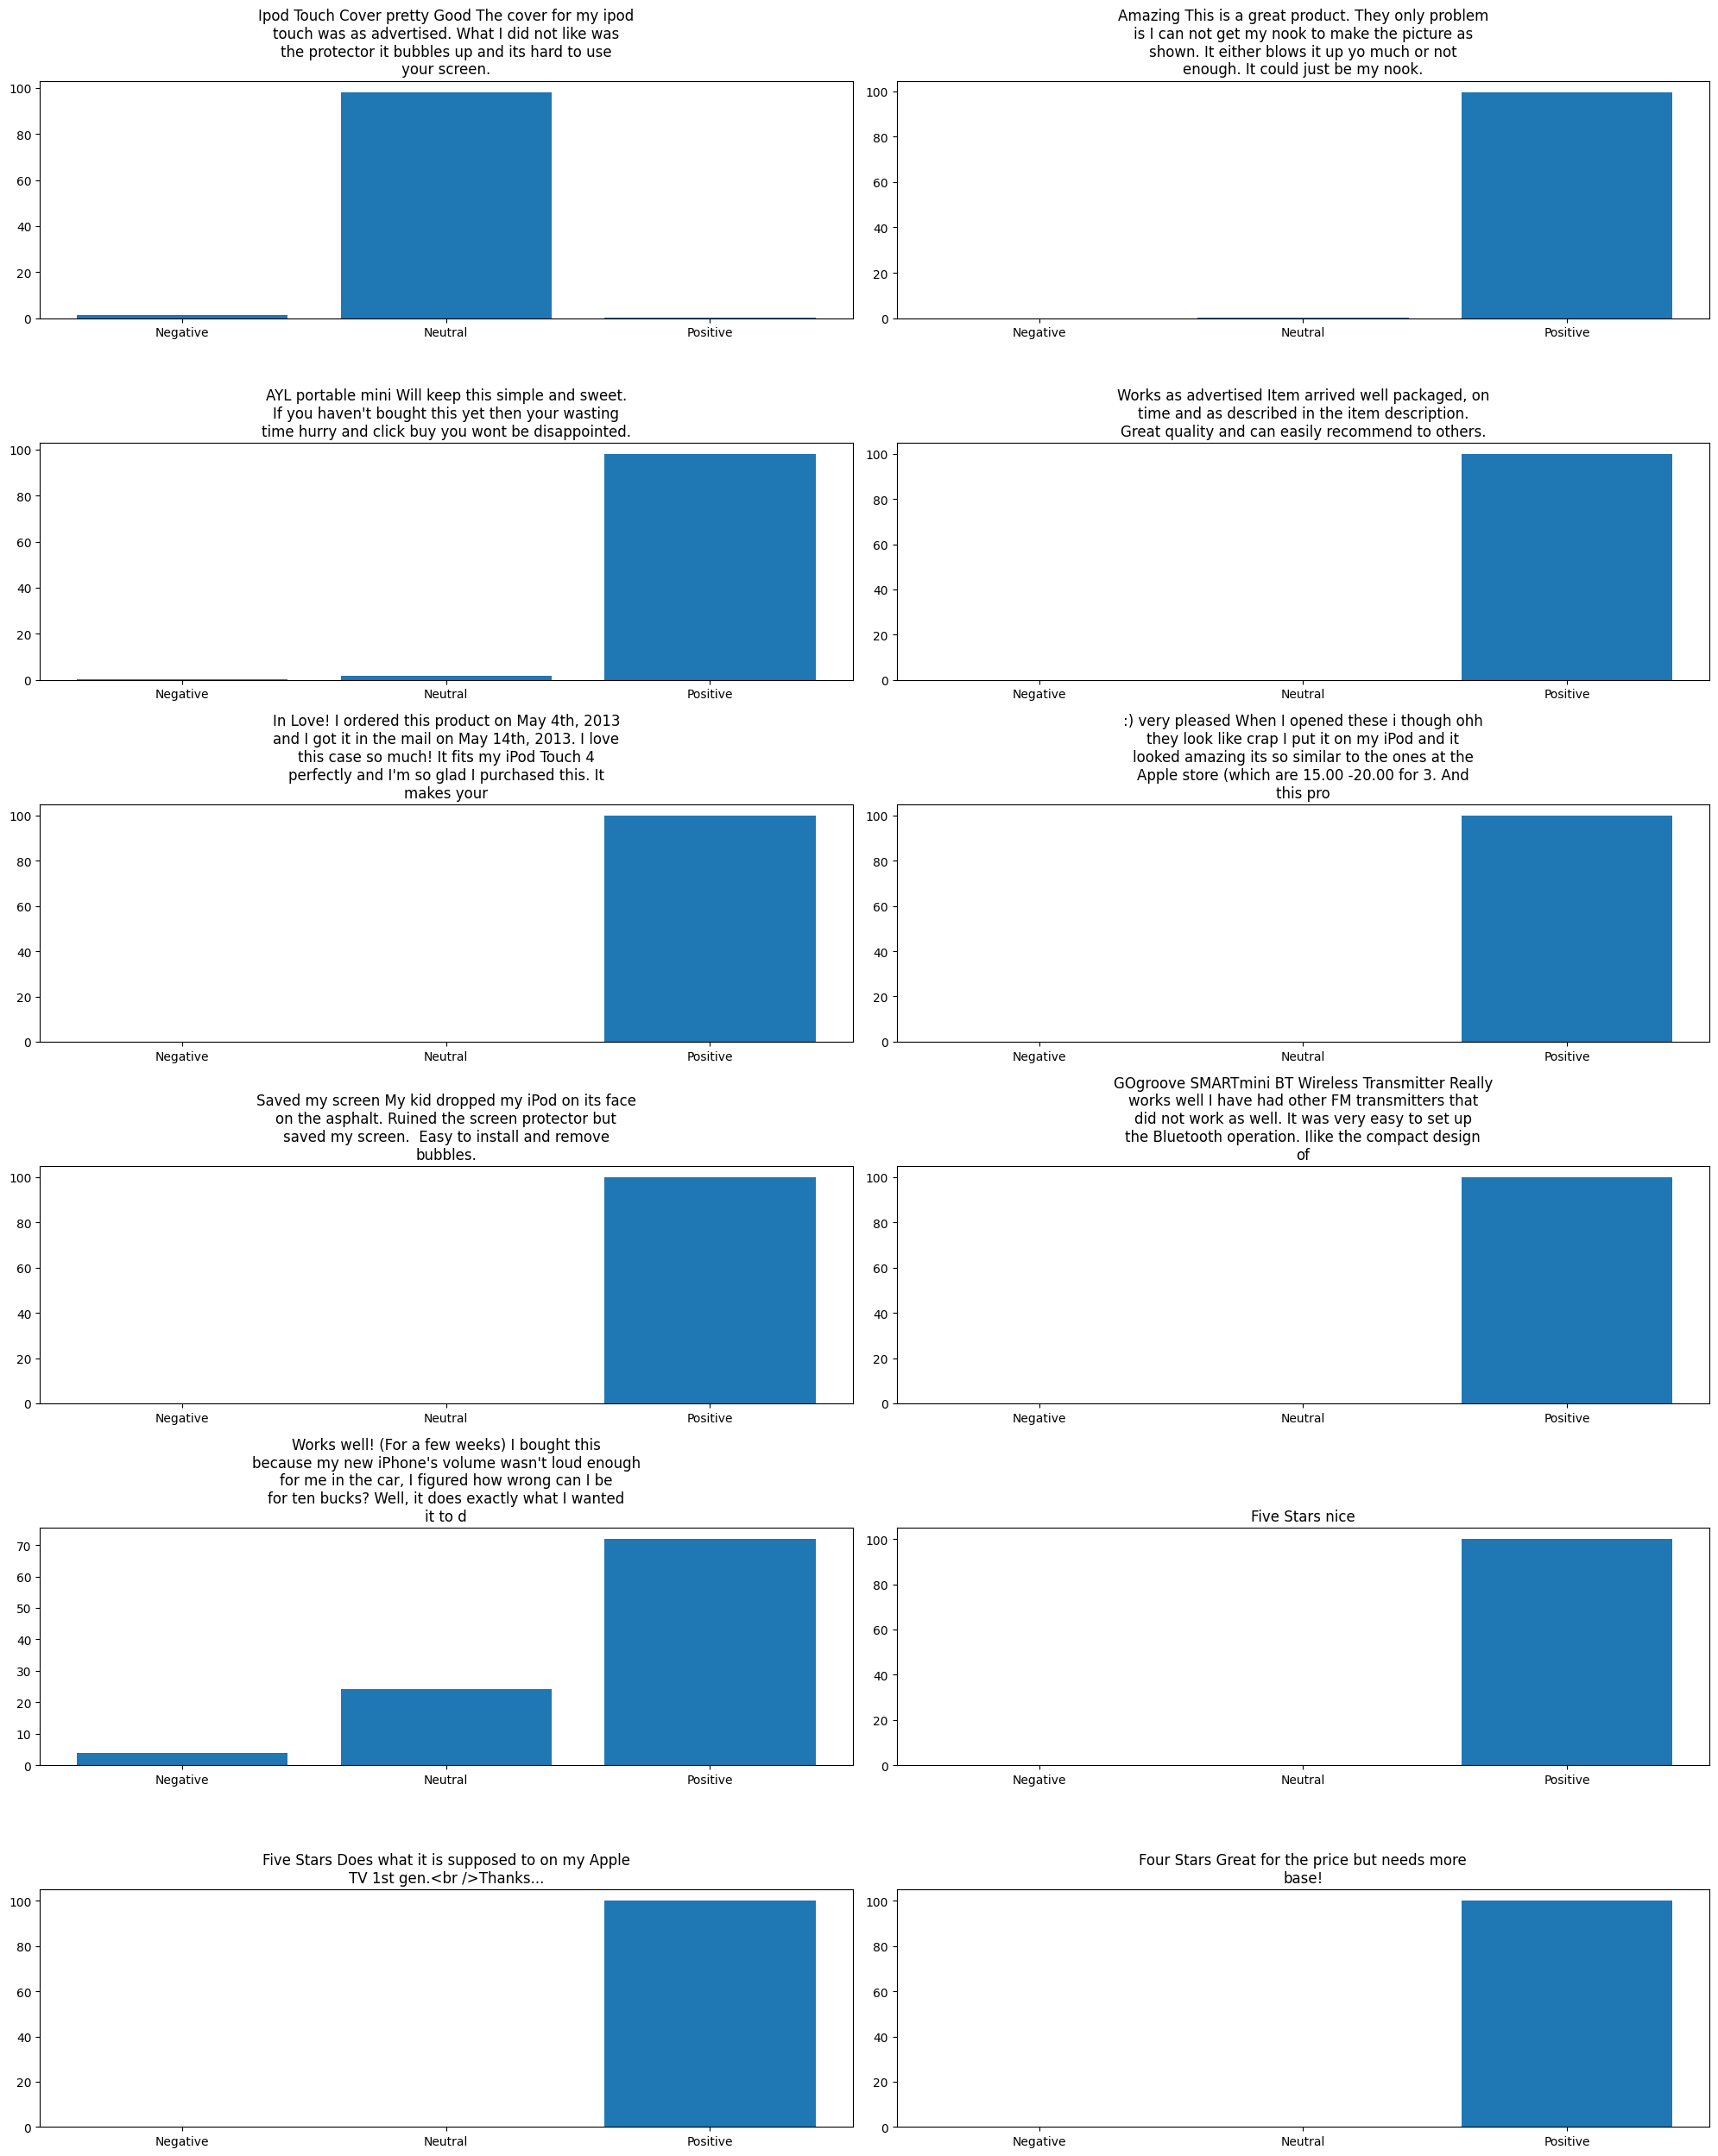

In [95]:
labels = review_encoded["test"].features["label"].names # 3 targets classifying the emotions
plot_preds(labels)

# EDA topics and Trends in reviews

In [96]:
# Install RAPIDS cuDF
!pip install rapidsai nvidia cudf==23.08

  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement nvidia (from versions: none)
ERROR: No matching distribution found for nvidia


In [97]:
file_path = '/content/drive/My Drive/Capstone/amazon_reviews_us_Mobile_Electronics_v1_00.tsv'
folder_path = '/content/drive/My Drive/Capstone'

In [98]:
import cudf
df = cudf.read_csv(f'{folder_path}/processed.csv', header=0)


In [99]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [100]:
df = df.drop(columns=columns_to_remove, errors="ignore")

In [101]:
df.head()

,customer_id,product_id,product_title,star_rating,verified_purchase,review_headline,review_body,review_date,sentiment
0,20422322,B00MC4CED8,BlackVue DR600GW-PMP,5.0,Y,Very Happy!,"As advertised. Everything works perfectly, I'm...",2015-08-31,Positive
1,40835037,B00OQMFG1Q,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,5.0,Y,five star,it's great,2015-08-31,Positive
2,51469641,B00QERR5CY,iXCC Multi pack Lightning cable,5.0,Y,great cables,These work great and fit my life proof case fo...,2015-08-31,Positive
3,4332923,B00QUFTPV4,abcGoodefg® FBI Covert Acoustic Tube Earpiece ...,4.0,Y,Work very well but couldn't get used to not he...,Work very well but couldn't get used to not he...,2015-08-31,Positive
4,44855305,B0067XVNTG,Generic Car Dashboard Video Camera Vehicle Vid...,2.0,Y,Cameras has battery issues,"Be careful with these products, I have bought ...",2015-08-31,Negative


In [102]:
df['cleaned_review'] = df['review_body'].str.lower().str.replace('[^a-z\s]', '', regex=True)

In [103]:
pip install bertopic[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 12.7 MB/s eta 0:00:00


In [104]:
## drop nulls
df = df.dropna()

## Get the topics

In [105]:
from bertopic import BERTopic

model = BERTopic()
_, topics = model.fit_transform(df['cleaned_review'].to_pandas())

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [106]:
df["topics"] = topics

## Visualize Negative sentiments

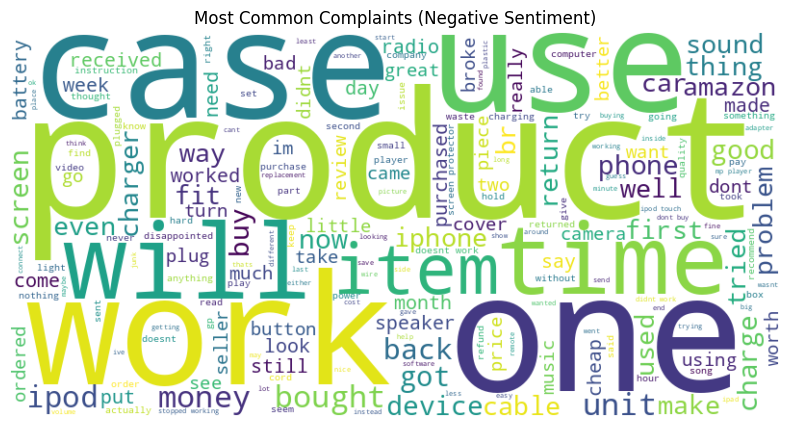

In [107]:
from wordcloud import WordCloud

# Generate word cloud for negative reviews
negative_reviews = ' '.join(df[df['sentiment'] == 'Negative']['cleaned_review'].to_pandas())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Complaints (Negative Sentiment)')
plt.show()


## Visualize Positive sentiments

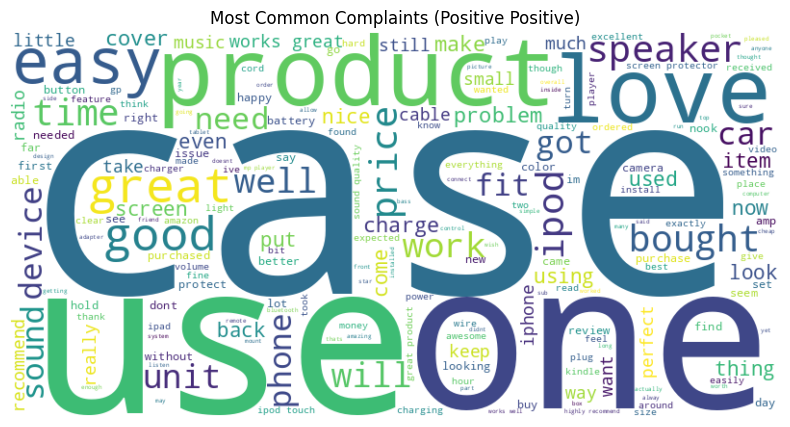

In [108]:
# Generate word cloud for positive reviews
positive_reviews = ' '.join(df[df['sentiment'] == 'Positive']['cleaned_review'].to_pandas())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Complaints (Positive Positive)')
plt.show()

## Visualize Neutral sentiments

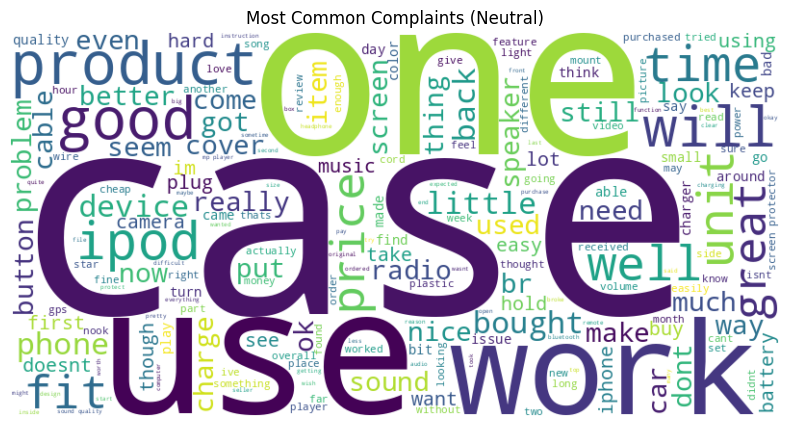

In [109]:
# Generate word cloud for neutral reviews
neutral_reviews = ' '.join(df[df['sentiment'] == 'Neutral']['cleaned_review'].to_pandas())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_reviews)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Complaints (Neutral)')
plt.show()

From the word clouds we can clearly see that this is a dataset on electronics. Given by the words cable, camera, iphone, audo, power, charce, radio, device etc